# Description of this jupyter notebook
* This notebook continues off from the [Bar_Crawl_import_initialEDA_featureEngineering Jupyter notebook](./Bar_Crawl_import_initialEDA_featureEngineering.ipynb)
* Contains codes for EDA, feature elimination, model building, model selection, and final summary

# Goal
* we want look at a 10 seconds window of acc. data to predict whether someone is intoxicated (binary class)
    * TAC 0.08 is the legal limit for driving - above which is considered intoxicated

# Apporach to building the model
1. Check for missing data (don't expect any) and then link the accelerometer data from the 13 participants to their TAC readings (merge data)
2. Do EDA - looking at correlation, distribution, etc
3. feature engineering
    * basic summary statistics from time domain
    * some features from frequency domain
4. Pre-process data for modeling - train/test split
5. Build a model
    * Looks like a basic binary classificaiton problem -> TAC above 0.08 or TAC below 0.08
    * basically want to predict: intoxicated / not-intoxicated
5. Try different models, hyperparamter tuning
6. Summarize

# Summary
## Features
* for calculating featuers, first separated by participant id, then calculated the features for a 10 seconds window
* each 10 seconds window for each participant becomes one row, column is the individual features

### features engineered:
* time domain features
    * max
    * min
    * mean
    * meidan
    * variance
    * kurtosis
    * skewness
    * interval
    * Root Mean Square (RMS)
* frequency domain features
    * zero crossings
    * spectral entropy
    * spectral density
    * spectral centroids
    * mfcc factors
    * spectral rolloffs (did not use)
    
### other potential features that are not engineered:
* gait-like features
    * number of steps
    * step strength
* frequency domain features
    * fft max frequency
    * fft min frequency
    
## Data Preprocessing / Cleaning / Merging

### data preprocessing
* No missing data as indicated
* Accelerator time is converted from unix timestamp to real time based on ms
* TAC timestamp is converted from unix timestamp to real time based on s
* Min-Max Scaling for the accelerator data for each participant before going through the 10s resampling
* For the TAC data:
    * above or equal to 0.08 is set as intoxicated (case 1)
    * lower than 0.08 is set as NOT intoxicated (case 0)
        
## data merging
1. To merge the accerlerator 10s window data with the TAC reading data (every 30min), I set:
    * TAC start_time = TAC timestamp
    * TAC end_time = TAC timestamp + 30 minutes
2. If the 10s acc window falls within the 30min of the TAC, then get the TAC reading information

## Model Selection
1. Holdout 20% of the data as test set
2. Compare bewteen Logistic Regression, SVM, Decision Tree and Random Forest
    * Decision Tree and Random Forest preforms the best but Decision Tree is simplier and easier to interpret
        * They are overfitting with a training accuracy of 100%
3. Hyper-parameter tuning for the Decision Tree model
    * max_depths
    * minimum samples per leaf
4. Metrics:
    * Training set:
        * 96.1% accuracy on training
    * Cross Validation on Training Set:
        * 68.5% accuracy with 5-fold cross-validation
        * 0.513 f1-score (out of 1)
    * Test set:
        * 93.2% accuracy on test set
        * 0.896 f1-score (out of 1)

# Import the final dataset and performing basic EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

* Because github only accept files under 100MB, I split the merged dataset into 2 files using splitting_df_into_smaller_files.ipynb

In [2]:
files_list = ['merged_df1.csv','merged_df2.csv']
folder_link = './data/output_files/'

In [3]:
def combine_db_from_folder(folder_link,files_list):
    """
    Take in the filepath to a folder containing csv files and a list containing the csv names,
    read in the csv as dataframes
    and return a combined dataframes with a column specifying where the file comes from
    
    input:
    folder_link : the filepath of the folder containing the csv files
    files_list : a list containing the name of the files inside the folder-file name follow format "BK7610_clean_TAC.csv"
    
    output:
    combined = a pandas dataframe contanining all the entries from the different files
    """
    combined = pd.DataFrame()
    for file in files_list:
        ind_db = pd.read_csv(folder_link+file)
        combined = pd.concat([ind_db,combined])
    return combined

In [4]:
clean_merge = combine_db_from_folder(folder_link,files_list)

In [5]:
clean_merge.head()

,pid__x,time_,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,...,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,TAC_Reading,intoxicated
0,SA0297,2017-05-02 17:58:10,42.0,5.282973,0.000615,6.113494,46.0,4.991548,0.000313,5.644283,...,0.0077,0.009498,0.00950,2.923647e-07,0.107379,0.131725,0.0034,0.009514,0.182644,1
1,SA0297,2017-05-02 17:58:10,42.0,5.282973,0.000615,6.113494,46.0,4.991548,0.000313,5.644283,...,-0.2436,-0.002826,-0.00475,4.611911e-03,1.764429,0.208733,0.4911,0.067885,0.182644,1
2,SA0297,2017-05-02 17:58:10,42.0,5.282973,0.000615,6.113494,46.0,4.991548,0.000313,5.644283,...,-0.2118,-0.007926,-0.00580,3.160200e-03,1.842521,-0.421897,0.3951,0.056644,0.182644,1
3,SA0297,2017-05-02 17:58:10,42.0,5.282973,0.000615,6.113494,46.0,4.991548,0.000313,5.644283,...,-0.7261,0.006971,0.00095,3.234918e-02,3.438768,-0.559695,1.2528,0.179768,0.182644,1
4,SF3079,2017-05-02 17:58:10,72.0,5.545490,0.001192,4.493106,57.0,5.873763,0.000626,5.746770,...,-0.0137,0.016055,0.01590,4.948490e-05,39.193064,3.693956,0.1019,0.017525,0.095807,1


In [6]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

correlation_matrix = clean_merge.corr()
correlation_matrix

,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,z_zerocrossings,z_entropy,z_density,z_centroids,x_mfcc_1,x_mfcc_2,x_mfcc_3,x_mfcc_4,x_mfcc_5,x_mfcc_6,x_mfcc_7,x_mfcc_8,x_mfcc_9,x_mfcc_10,x_mfcc_11,x_mfcc_12,x_mfcc_13,y_mfcc_1,y_mfcc_2,y_mfcc_3,y_mfcc_4,y_mfcc_5,y_mfcc_6,y_mfcc_7,y_mfcc_8,y_mfcc_9,y_mfcc_10,y_mfcc_11,y_mfcc_12,y_mfcc_13,z_mfcc_1,z_mfcc_2,z_mfcc_3,z_mfcc_4,z_mfcc_5,z_mfcc_6,z_mfcc_7,z_mfcc_8,z_mfcc_9,z_mfcc_10,z_mfcc_11,z_mfcc_12,z_mfcc_13,x_max,x_min,x_mean,x_median,x_var,x_kurtosis,x_skewness,x_interval,x_rms,y_max,y_min,y_mean,y_median,y_var,y_kurtosis,y_skewness,y_interval,y_rms,z_max,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,TAC_Reading,intoxicated
x_zerocrossings,1.000000,0.297911,-0.112423,0.749349,0.724602,0.446306,-0.012112,0.565199,0.220960,0.049708,-0.012112,0.165191,-0.188373,-0.471109,0.011736,0.017461,-0.132009,-0.052864,-0.156850,-0.074209,-0.162857,-0.021339,0.039802,0.003743,0.167237,-0.233281,-0.412180,-0.119087,-0.060761,-0.021596,0.009889,0.032240,-0.012877,-0.091322,-0.033439,0.043561,0.010463,0.148231,-0.189918,-0.378165,0.161089,0.078946,-0.037682,0.066158,-0.116402,0.012443,-0.088225,0.061355,0.142629,0.108188,0.236331,-0.076053,0.080204,0.000357,0.000214,-0.045536,-0.017445,0.008063,-0.084212,-0.090975,0.063301,0.064673,0.064302,0.064408,-0.013309,-0.026443,-0.012052,-0.015733,-0.064464,-0.064673,-0.063301,-0.064302,-0.064408,-0.013309,-0.032617,0.015078,-0.015733,-0.064464,-0.231680,-0.186449
x_entropy,0.297911,1.000000,-0.104818,0.375662,0.390272,0.703124,-0.026531,0.346648,-0.259413,0.591889,-0.026531,-0.150565,-0.061040,-0.199716,-0.437666,-0.138536,0.151612,-0.028004,0.435724,-0.020782,0.316535,-0.036692,0.016688,-0.045568,-0.110435,-0.045598,-0.151218,-0.176315,-0.118988,-0.016129,-0.062707,0.246875,-0.000315,0.196314,-0.003396,0.031519,-0.036464,-0.036846,-0.104561,-0.133034,-0.390657,-0.087517,0.247203,0.056597,0.483750,0.086866,0.381183,0.078709,0.099270,0.060808,-0.035542,-0.024340,0.032445,0.012153,0.012335,-0.030712,0.031827,0.005673,-0.030509,-0.061132,0.028583,0.029681,0.029316,0.029367,-0.010856,0.017117,0.000180,-0.011466,-0.029471,-0.029681,-0.028583,-0.029316,-0.029367,-0.010856,0.011457,0.001750,-0.011466,-0.029471,-0.117635,-0.077066
x_density,-0.112423,-0.104818,1.000000,-0.111128,-0.170854,-0.144601,0.002849,-0.190215,-0.021539,-0.042707,0.002849,-0.030214,0.281159,0.111362,-0.014684,0.013547,0.029068,0.017235,-0.021039,-0.034644,-0.007673,-0.024260,-0.049175,-0.005737,-0.050280,0.332248,0.088381,-0.031874,-0.000925,0.059030,0.082015,0.023025,0.019136,-0.013426,-0.016797,-0.010496,0.009309,-0.033923,0.336054,0.028721,-0.027068,0.031184,0.030443,-0.015635,0.014208,-0.018250,-0.020256,-0.035032,-0.035610,-0.019976,-0.056419,0.141108,-0.140148,-0.002634,-0.006173,0.177003,0.014951,0.002513,0.151699,0.126630,-0.020746,-0.020824,-0.020863,-0.020843,-0.000240,0.014175,-0.008472,0.001765,0.020845,0.020824,0.020746,0.020863,0.020843,-0.000240,0.009157,-0.012946,0.001765,0.020845,0.044658,0.022318
x_centroids,0.749349,0.375662,-0.111128,1.000000,0.649116,0.463926,-0.017487,0.763616,0.006709,0.143976,-0.017487,0.205070,-0.365728,-0.816890,-0.202494,-0.098567,-0.106259,-0.049734,-0.043819,-0.007665,-0.038566,0.038924,0.078818,0.062234,0.154145,-0.371718,-0.659738,-0.252771,-0.116364,-0.029450,-0.009096,0.078178,0.029092,0.002134,0.030149,0.073943,0.045657,0.150681,-0.340664,-0.640047,-0.008148,0.013894,0.018873,0.097008,0.024229,0.116116,0.047514,0.156686,0.196615,0.180591,0.247410,-0.102346,0.109010,0.006172,0.006315,-0.055981,-0.053214,0.003648,-0.113892,-0.119328,0.079705,0.081502,0.080928,0.080995,-0.017941,-0.060923,-0.020724,-0.020438,-0.081166,-0.081502,-0.079705,-0.080928,-0.080995,-0.017941,-0.073856,0.021699,-0.020438,-0.081166,-0.359231,-0.296307
y_zerocrossings,0.724602,0.390272,-0.170854,0.649116,1.000000,0.602504,-0.018971,0.772016,0.061944,0.186293,-0.018971,0.104260,-0.361243,-0.552874,-0

In [7]:
correlation_matrix['intoxicated'].sort_values(ascending=False)

# Need to drop TAC_Reading --> intoxicated field comes from TAC_reading
# participant id (pid) is already dropped

intoxicated        1.000000
TAC_Reading        0.812042
y_mfcc_2           0.373682
x_mfcc_2           0.367924
z_mfcc_2           0.341980
x_mfcc_1           0.241265
y_mfcc_1           0.183955
z_mfcc_1           0.152749
z_zerocrossings    0.123772
z_kurtosis         0.116220
x_kurtosis         0.114589
x_rms              0.100012
y_kurtosis         0.099644
z_min              0.093135
x_interval         0.092813
z_mean             0.092592
y_rms              0.092511
z_rms              0.092511
z_median           0.092333
z_max              0.092310
z_centroids        0.089933
x_max              0.082916
x_mfcc_4           0.056095
y_mfcc_3           0.053612
x_var              0.044158
z_entropy          0.033262
x_mfcc_7           0.027935
y_skewness         0.026789
x_density          0.022318
y_mfcc_4           0.016515
x_mfcc_9           0.010792
x_mfcc_5           0.007883
z_mfcc_5           0.004917
x_median           0.003366
x_mean             0.002842
z_var              0

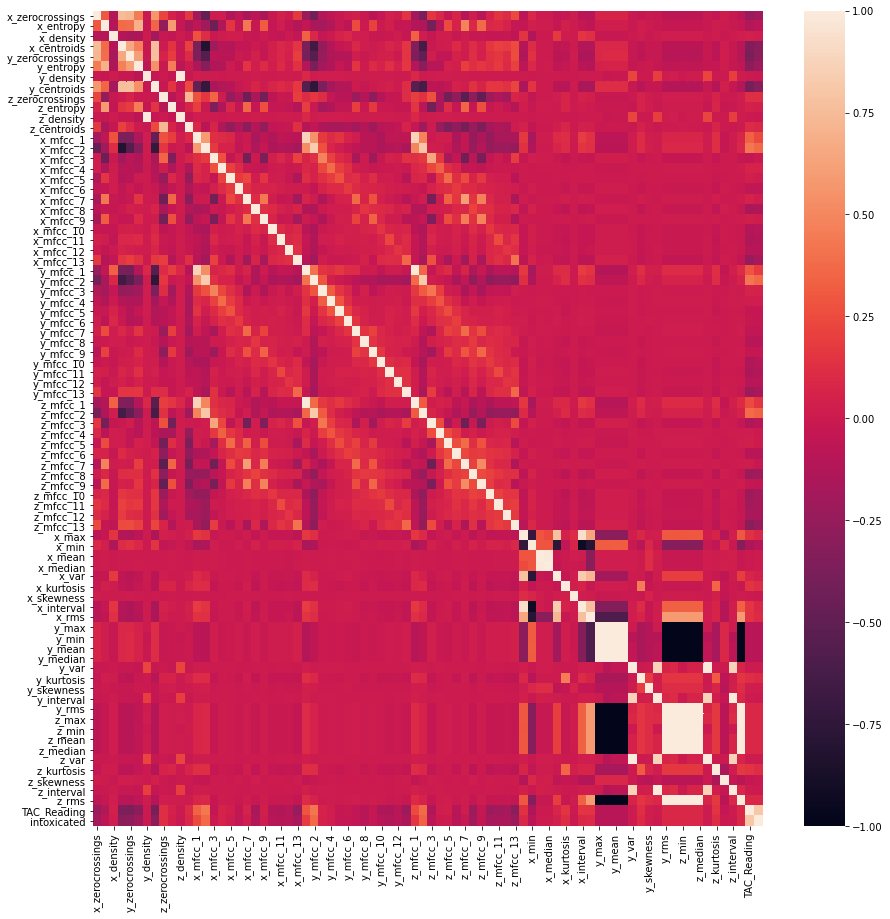

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix)

* Pretty high correlation between:
    * zerocrossings of each axis with each other
    * median and mean value
    * z_rms with y_rms with z_min with z_median with z_mean and z_max ---- z axis summary stat might be TOO correlated
    * need to be careful of multicolinearity - drop some highly correlated columns
* looking at intoxicated, highest correlation is:
    * mfcc factors
    * rms
    * zerocrossing (pos and neg correlated)
    * centroids(negatively correlated)

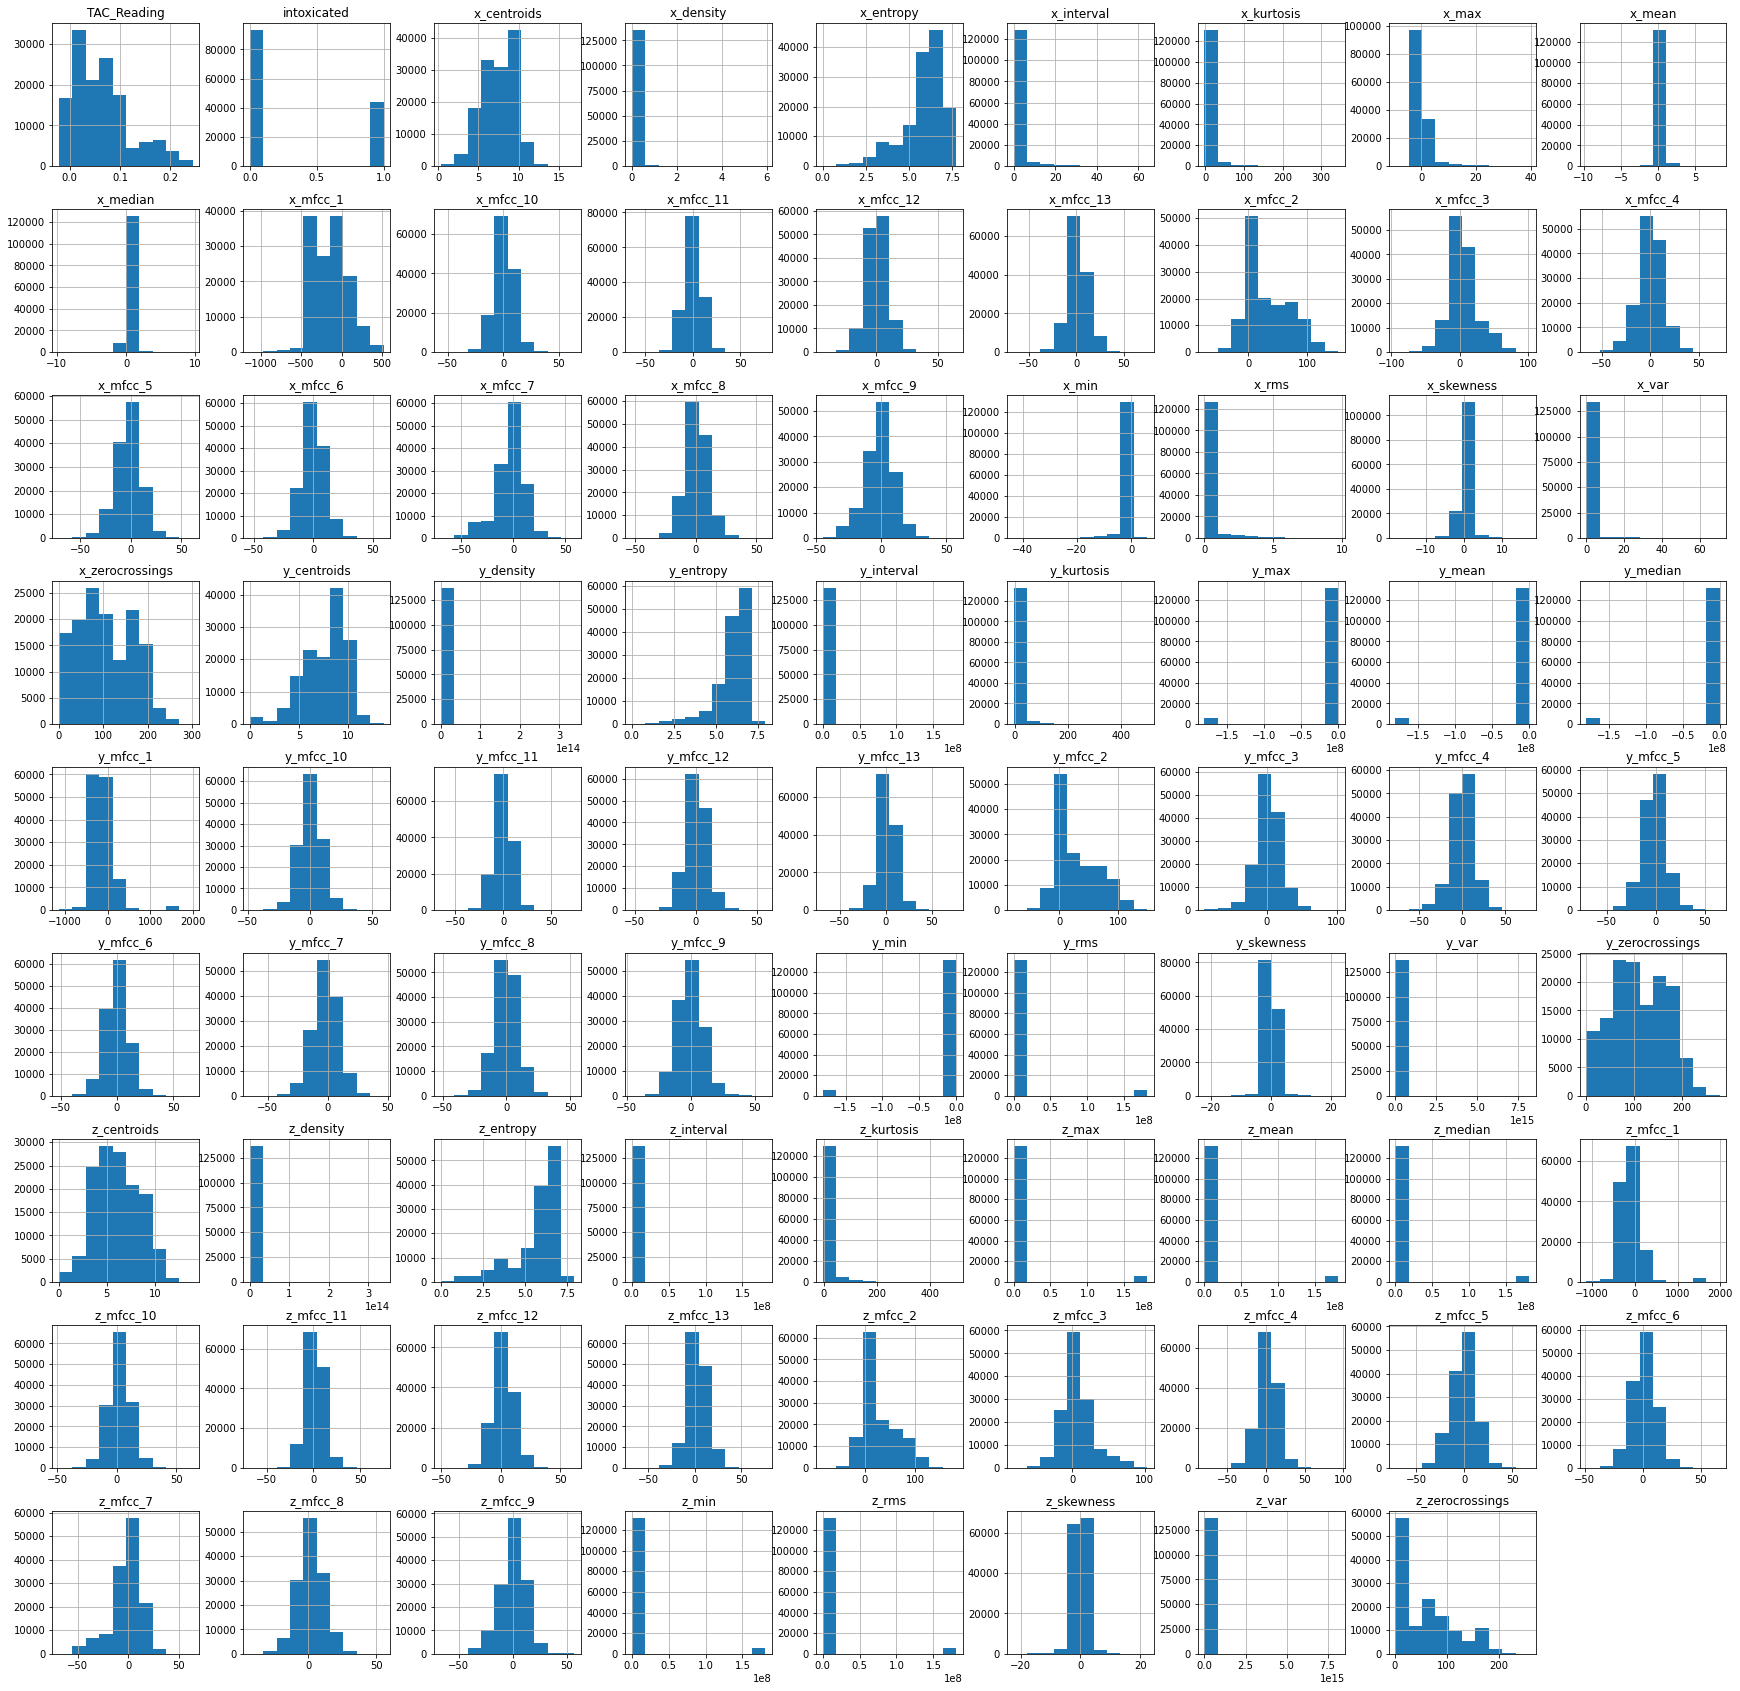

In [9]:
clean_merge.hist(figsize=(30,30)); # histogram of each column

* z time domain stats looks like there are a lot of 0

In [10]:
# getting rid of some columns - TAC_Reading is dropped
clean_merge = clean_merge.drop(columns=['pid__x','time_','TAC_Reading'])

# z columns are highly correlated and mostly 0 - so delete
# clean_merge = clean_merge.drop(columns=['z_min','z_var','z_max','z_rms','z_mean'])

# Splitting the data for train-test

In [11]:
from sklearn.model_selection import train_test_split

X = clean_merge.drop(columns=['intoxicated'])
y = clean_merge['intoxicated']

In [12]:
X.dtypes
# all numeric - good - also none of the features here is extracted from TAC_Reading, only from the accelerator data

x_zerocrossings    float64
x_entropy          float64
x_density          float64
x_centroids        float64
y_zerocrossings    float64
y_entropy          float64
y_density          float64
y_centroids        float64
z_zerocrossings    float64
z_entropy          float64
z_density          float64
z_centroids        float64
x_mfcc_1           float64
x_mfcc_2           float64
x_mfcc_3           float64
x_mfcc_4           float64
x_mfcc_5           float64
x_mfcc_6           float64
x_mfcc_7           float64
x_mfcc_8           float64
x_mfcc_9           float64
x_mfcc_10          float64
x_mfcc_11          float64
x_mfcc_12          float64
x_mfcc_13          float64
y_mfcc_1           float64
y_mfcc_2           float64
y_mfcc_3           float64
y_mfcc_4           float64
y_mfcc_5           float64
y_mfcc_6           float64
y_mfcc_7           float64
y_mfcc_8           float64
y_mfcc_9           float64
y_mfcc_10          float64
y_mfcc_11          float64
y_mfcc_12          float64
y

In [13]:
y.value_counts()

0    93439
1    43894
Name: intoxicated, dtype: int64

In [14]:
len(y[y==0])/y.shape[0]*100 # percentage of not drunk out of total

68.03827193755325

* not drunk (TAC_reading lower than 0.08) case is slightly overrepresented but not too bad

In [15]:
len(y)

137333

In [16]:
X.shape

(137333, 78)

In [17]:
# splitting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=37,test_size=0.2, shuffle=True)
# 20% test data hold out to evaluate final model

* If the purpose is to test whether the model would do well with new participants, perhaps it would make sense to hold out 20% of the 13 participants, so hold out 2 participants as test, and use the data from 11 as train
* Right now the train,test split is hold out 20% of the 10s window data as test set

In [18]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_train shape:",y_test.shape)

X_train shape: (109866, 78)
X_test shape: (27467, 78)
y_train shape: (109866,)
y_train shape: (27467,)


# Training models : Logistic, SVM, Random Forest

* Trying a few (binary) classification model
    * Logistic Regression is the simplest, but in this case I have multicollineary, which is not very compatible with logsitic regression
    * SVM - takes a long time to trian and linear model might not do well, polynomial might be better?
    * Decision Tree - prone to overfitting, would randomly pick one vs the other for highly correlated features
    * Random Forest - would reduce overfitting of decision tree, but make it less interpretable

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score
from sklearn.model_selection import cross_validate,cross_val_predict
import numpy as np

In [20]:
# Define dictionaries to store the accuracy of different models

train_accuracies = {}
cv_accuracies = {}
f1_scores = {}

def fit_model_get_stats(model,model_name,cv=5,X_train=X_train,y_train=y_train):
    model.fit(X_train,y_train)
    predictions = cross_val_predict(model,X_train,y_train,cv=cv) # use cross-validation for comparing models
    train_accuracies[model_name] = model.score(X_train,y_train)
    cv_accuracies[model_name] = accuracy_score(y_train,predictions)
    f1_scores[model_name] = f1_score(y_train,predictions)
    return model,predictions

In [21]:
# logistic regression the simpliest method but might be too simple to perform well
# also mulitcolinearity would be a big problem for logistic regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model, lr_predictions = fit_model_get_stats(lr_model,'lr_model')

In [22]:
# decision tree is prone to overfitting
from sklearn.tree import DecisionTreeClassifier
# Decision Tree Classifier
tree_model = DecisionTreeClassifier()
tree_model, tree_predictions = fit_model_get_stats(tree_model,'tree_model')

In [23]:
# svm is very slow - would a linear, polynomial kernel be better?
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model, svm_predictions = fit_model_get_stats(svm_model,'svm_model')

/home/eyan/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eyan/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eyan/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eyan/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eyan/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarni

In [24]:
# Random Forest ensemble model reduces overfitting by having many trees made with different bootstraped sample
# but is harder to interrupt
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model, forest_predictions = fit_model_get_stats(forest_model,'forest_model')

In [25]:
stats = pd.DataFrame.from_dict([train_accuracies,cv_accuracies,f1_scores])
stats.index = ['train_accuracy','cv_accuracy','f1_scores']
stats
# out of 1

,lr_model,tree_model,svm_model,forest_model
train_accuracy,0.623769,1.000000,0.676497,1.000000
cv_accuracy,0.632681,0.671674,0.546591,0.696679
f1_scores,0.149799,0.483588,0.409916,0.512556


* Multicollineary is a problem for logistic regression - LR did terribly
* Random Forest seems to do the best, but decision tree is close second
* Both decision tree and random forest models are overfitted to the train set because training accuracy is 1
    * Since the case 0 and case 1 are roughly balanced (67% case 0), accuracy is not too bad of a metrics
    * Use a decision tree model to go forward since it is a simpler model, tune the parameters
* Accuracy is not great, since we have 67% case 0, and the cross validation accuracy is 67%

## Hyperparamter Tuning

In [29]:
# Define dictionaries to store the accuracy of different models
from sklearn.model_selection import GridSearchCV

In [30]:
max_depths = [5,10,15,20]
num_leafs = [1, 5, 10, 20, 50, 100]
param_grid = [{'max_depth':max_depths,
              'min_samples_leaf':num_leafs}]

gs = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
best_model = gs.best_estimator_

0.9266288217204405
{'max_depth': 20, 'min_samples_leaf': 1}


In [31]:
best_model = DecisionTreeClassifier(max_depth=20,min_samples_leaf=1,random_state=37)
best_model, best_predictions = fit_model_get_stats(best_model,'best_model')

In [32]:
stats = pd.DataFrame.from_dict([train_accuracies,cv_accuracies,f1_scores])
stats.index = ['train_accuracy','cv_accuracy','f1_scores']
stats
# out of 1

,lr_model,tree_model,svm_model,forest_model,best_model
train_accuracy,0.623769,1.000000,0.676497,1.000000,0.961371
cv_accuracy,0.632681,0.671674,0.546591,0.696679,0.684519
f1_scores,0.149799,0.483588,0.409916,0.512556,0.516472


* Cross Validation accuracy is a bit low still (68%) but then f1 score improved
* Test score is so much higher below

In [ ]:
# a function to get test prediction
def get_test_prediction(best_model=best_model, X_test=X_test,y_test=y_test):
    """
    intake the model to run test prediciton on and prints out the test accuracy, f1-score, and classificaiton report,
    return the confusion matrix
    input:
    best_model: the model to run test prediction on
    X_test: test set features
    y_test: test set target
    output:
    confusion matrix: confusion matrix from comparing the true test target and the predicted target
    """
    test_predictions = best_model.predict(X_test)
    print("test accruacy for best model:", best_model.score(X_test,y_test))
    print("test f1 score for best model:",f1_score(y_test,test_predictions))
    print(classification_report(y_test, test_predictions))
    return confusion_matrix(y_test, test_predictions)

In [33]:
test_predictions = best_model.predict(X_test)

In [41]:
test_acc = best_model.score(X_test,y_test) # test score accuracy
print("test accruacy for best model:",test_acc)

test accruacy for best model: 0.9320639312629702


In [42]:
print("test f1 score for best model:",f1_score(y_test,test_predictions))

test f1 score for best model: 0.8959750250864088


In [35]:
confusion_mat = confusion_matrix(y_test, test_predictions)
print(confusion_mat)

[[17565  1133]
 [  733  8036]]


Text(0.5, 15.0, 'Predicted')

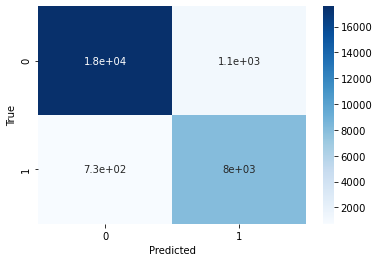

In [37]:
sns.heatmap(confusion_mat, annot=True, cmap='Blues')

plt.ylabel("True")
plt.xlabel("Predicted")

In [36]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     18698
           1       0.88      0.92      0.90      8769

    accuracy                           0.93     27467
   macro avg       0.92      0.93      0.92     27467
weighted avg       0.93      0.93      0.93     27467



# Visualizing a decision tree

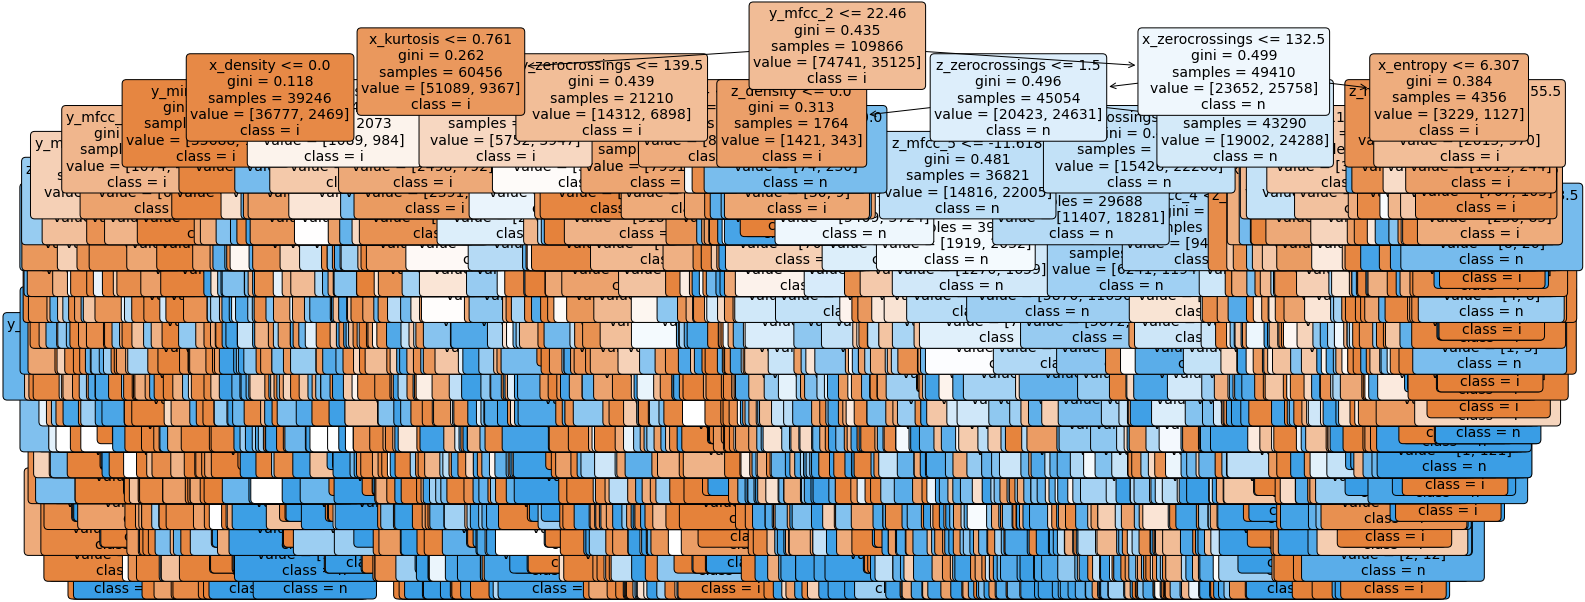

In [38]:
# this is a really big tree --- should trim more
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
a = plot_tree(best_model, 
              feature_names=X.columns, 
              class_names='intoxicated', 
              filled=True, 
              rounded=True, 
              fontsize=14)

# Result
* Decision Tree model with 78 features
* Binary classificaiton - intoxicated (case 1) or not intoxicated (case 0)
    * We have 67% not intoxicated out of 137333 rows (10s window)
* Final test set accuracy and f1-score
    * **93.2% accuracy on test set**
    * **0.896 f1-score (out of 1)**

|   | precision | recall | f1-score |   |
|---|-----------|--------|----------|---|
| not intoxicated | 0.96      | 0.94   | 0.95     |   |
| intoxicated | 0.88      | 0.92   | 0.90     |   |


# Things to think about
* How to deploy the model (real-life use case)
    - Want to be able to read accerlerator data and return a prediction and warn the user when their TAC reading rises: This would require predicting TAC reading (regression) instead of a binary classification
    - Even if it is a binary classification, want real-time prediction.
* Alternative way to train/test split the data for model training and testing:
    * Hold out 2 of the 13 participants as test set, then train the model on the 11.
* What features to eliminate / add?
    * There are some features that are highly correlated with each other (multicollineary) that can be eliminated
        * Less of a problem for decision tree since it will randomly pick one as the important feature, but still should get rid of some
        * Can use Recursive Feature Elimination to eliminate some features
    * There are some features that can be added see above section - other potential features that are not engineered
